In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as tlt
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import r2_score

In [148]:
dataset= pd.read_csv('Ecommerce.csv')
dataset
dataset.head()

,customer_id,session_id,visit_date,device_type,user_type,marketing_channel,product_id,product_category,unit_price,quantity,...,review_text,review_helpful_votes,payment_method,visit_day,visit_month,visit_weekday,visit_season,session_duration_bucket,revenue_normalized,location
0,1803,0,28-11-2024,2,1,2,894,6,651.57,1,...,1,0,1,28,11,3,0,Long,0.000000,209
1,7964,1,25-09-2024,2,0,4,844,2,945.27,4,...,1,0,2,25,9,2,0,Long,0.000000,213
2,6890,2,31-05-2024,1,1,0,865,0,400.44,4,...,1,0,2,31,5,4,1,Short,0.000000,10
3,4949,3,30-01-2024,1,0,2,851,3,1268.54,2,...,10,4,1,30,1,1,3,Very Long,0.305504,46
4,4896,4,25-02-2024,1,1,5,794,3,880.81,3,...,1,0,1,25,2,6,3,Very Short,0.000000,118


In [149]:
dataset=dataset[[
    'customer_id',
    'session_id',
    'product_category',
    'unit_price',
    'quantity',
    'purchased'
]]
dataset.head()

,customer_id,session_id,product_category,unit_price,quantity,purchased
0,1803,0,6,651.57,1,0
1,7964,1,2,945.27,4,0
2,6890,2,0,400.44,4,0
3,4949,3,3,1268.54,2,1
4,4896,4,3,880.81,3,0


In [150]:
dataset["aband"]=dataset["purchased"].apply(
    lambda x: 0 if x==1 else 1
)
dataset.head()

,customer_id,session_id,product_category,unit_price,quantity,purchased,aband
0,1803,0,6,651.57,1,0,1
1,7964,1,2,945.27,4,0,1
2,6890,2,0,400.44,4,0,1
3,4949,3,3,1268.54,2,1,0
4,4896,4,3,880.81,3,0,1


In [151]:
dataset["cart_value"]= dataset["unit_price"]*dataset["quantity"]
dataset.head()

,customer_id,session_id,product_category,unit_price,quantity,purchased,aband,cart_value
0,1803,0,6,651.57,1,0,1,651.57
1,7964,1,2,945.27,4,0,1,3781.08
2,6890,2,0,400.44,4,0,1,1601.76
3,4949,3,3,1268.54,2,1,0,2537.08
4,4896,4,3,880.81,3,0,1,2642.43


In [152]:
cat_aband= dataset.groupby("product_category")["aband"].mean().reset_index()

In [153]:
cat_aband["aband"]*=100
cat_aband

,product_category,aband
0,0,77.721197
1,1,78.738087
2,2,77.726290
3,3,79.243421
4,4,77.309613
5,5,76.881550
6,6,75.321337
7,7,77.416206


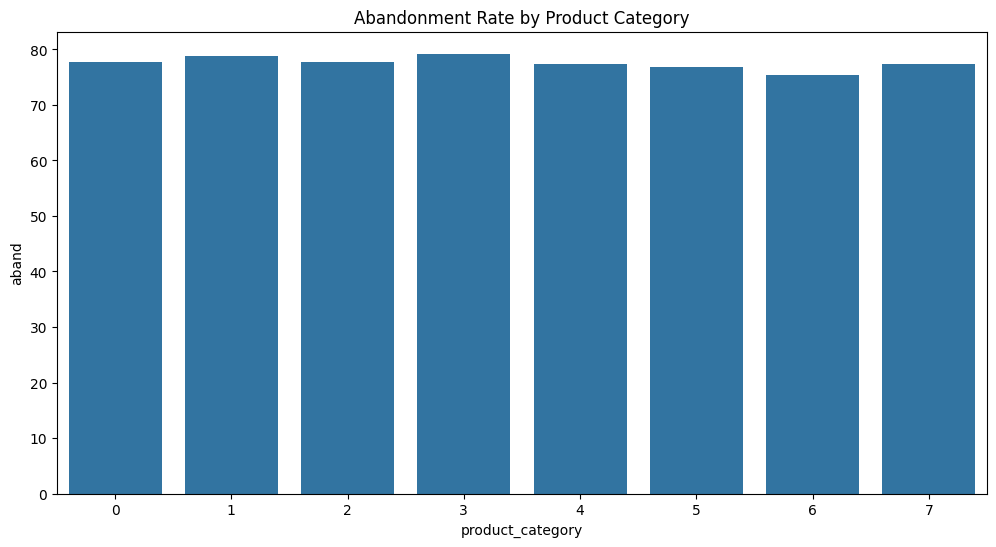

In [154]:
plt.figure(figsize=(12,6))
sns.barplot(data=cat_aband,
            x='product_category',
            y='aband'
)
plt.title("Abandonment Rate by Product Category")
plt.show()

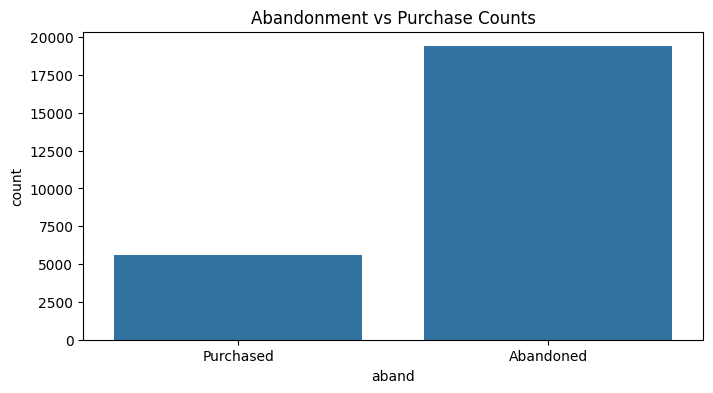

In [155]:
plt.figure(figsize=(8,4))
sns.countplot(
    x="aband",
    data=dataset
)

plt.title("Abandonment vs Purchase Counts")
plt.xticks([0,1], ['Purchased', 'Abandoned'])
plt.show()

In [156]:
print("summary Statistics:")
print(dataset["cart_value"].describe())
print("\nOverall Abandonment Rate:",
      dataset["aband"].mean()*100,"%")

summary Statistics:
count    25000.000000
mean      1950.249582
std       1569.020621
min         51.000000
25%        774.872500
50%       1473.935000
75%       2733.375000
max       7993.160000
Name: cart_value, dtype: float64

Overall Abandonment Rate: 77.536 %


In [157]:
x=dataset[["cart_value"]]
y=dataset["aband"]


In [158]:
x_train, x_test, y_train, y_test= tlt(
    x,y, test_size=0.3
)

In [159]:
model= LogisticRegression()
model.fit(x_train, y_train)

y_prob= model.predict_proba(x_test)[:,1]
print("predicted probablity:",r2_score(y_test, y_prob))

predicted probablity: 0.00012242073494828087


In [160]:
sorted_idx=np.argsort(x_test.values.ravel())
x_sorted= x_test.values.ravel()[sorted_idx]
y_prob_sorted= y_prob[sorted_idx]

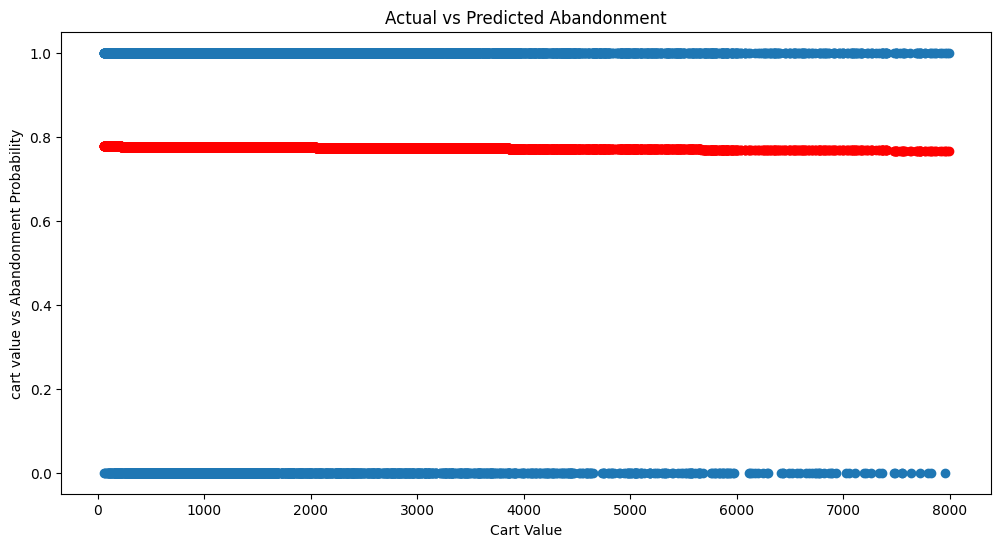

In [161]:
plt.figure(figsize=(12,6))
plt.scatter(x_test,y_test )
plt.scatter(x_sorted,y_prob_sorted, color="red")
plt.title("Actual vs Predicted Abandonment")
plt.xlabel("Cart Value")
plt.ylabel("cart value vs Abandonment Probability")
plt.show()

/tmp/ipykernel_84676/280106480.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat_data= (dataset_heat.groupby("cart_bin")["aband_prob"]


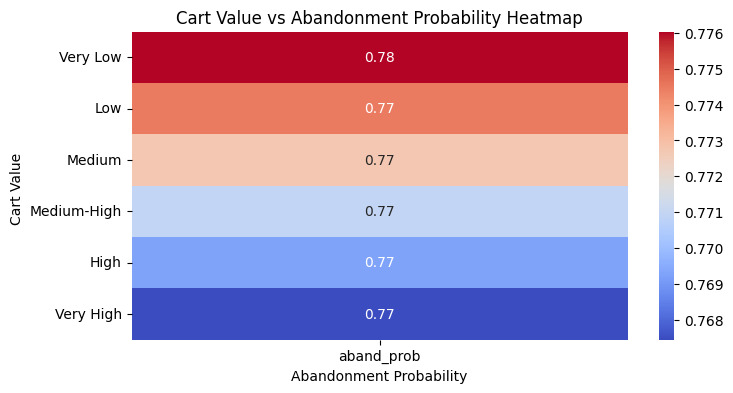

In [162]:
dataset_heat= pd.DataFrame({
    "cart_value": x_test["cart_value"],
    "aband_prob": y_prob
})

dataset_heat["cart_bin"] = pd.cut(
    dataset_heat["cart_value"],
    bins=6,
    labels=["Very Low", "Low", "Medium", "Medium-High","High", "Very High"]

)

heat_data= (dataset_heat.groupby("cart_bin")["aband_prob"]
            .mean()
            .to_frame()
            )

plt.figure(figsize=(8,4))
sns.heatmap(
    heat_data,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Cart Value vs Abandonment Probability Heatmap")
plt.xlabel("Abandonment Probability")
plt.ylabel("Cart Value ")
plt.show()
            